<a href="https://colab.research.google.com/github/ngolemai020405/Thuchanh_TTNT/blob/main/BaoCao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import copy
from heapq import heappush, heappop

n = 4
rows = [1, 0, -1, 0]
cols = [0, -1, 0, 1]

class PriorityQueue:
    def __init__(self):
        self.heap = []

    def push(self, key):
        heappush(self.heap, key)

    def pop(self):
        return heappop(self.heap)

    def empty(self):
        return len(self.heap) == 0

class Node:
    def __init__(self, parent, mats, empty_tile_posi, costs, levels):
        self.parent = parent
        self.mats = mats
        self.empty_tile_posi = empty_tile_posi
        self.costs = costs
        self.levels = levels

    def __lt__(self, nxt):
        return self.costs < nxt.costs

def calculateCosts(mats, final) -> int:
    count = 0
    for i in range(n):
        for j in range(n):
            if mats[i][j] != 0 and mats[i][j] != final[i][j]:
                count += 1
    return count

def newNodes(mats, empty_tile_posi, new_empty_tile_posi, levels, parent, final) -> Node:
    new_mats = copy.deepcopy(mats)

    x1, y1 = empty_tile_posi
    x2, y2 = new_empty_tile_posi
    new_mats[x1][y1], new_mats[x2][y2] = new_mats[x2][y2], new_mats[x1][y1]

    costs = calculateCosts(new_mats, final)

    return Node(parent, new_mats, new_empty_tile_posi, costs, levels)

def printMats(mats):
    for row in mats:
        print(" ".join(str(num) for num in row))
    print()

def isSafe(x, y):
    return 0 <= x < n and 0 <= y < n

def printPath(root):
    if root is None:
        return
    printPath(root.parent)
    printMats(root.mats)

def solve(initial, empty_tile_posi, final):
    pq = PriorityQueue()
    costs = calculateCosts(initial, final)
    root = Node(None, initial, empty_tile_posi, costs, 0)
    pq.push(root)

    while not pq.empty():
        minimum = pq.pop()

        if minimum.costs == 0:
            print("Giải pháp tìm thấy:")
            printPath(minimum)
            return

        for i in range(4):
            new_tile_posi = [
                minimum.empty_tile_posi[0] + rows[i],
                minimum.empty_tile_posi[1] + cols[i],
            ]

            if isSafe(new_tile_posi[0], new_tile_posi[1]):
                child = newNodes(minimum.mats,
                                 minimum.empty_tile_posi,
                                 new_tile_posi,
                                 minimum.levels + 1,
                                 minimum, final)

                pq.push(child)

initial = [
    [1, 2, 3, 4],
    [5, 6, 0, 8],
    [9, 10, 7, 11],
    [13, 14, 15, 12]
]

final = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 0]
]

empty_tile_posi = [1, 2]

solve(initial, empty_tile_posi, final)

In [ ]:
from collections import deque

class Graph:
    def __init__(self, adjac_lis):
        self.adjac_lis = adjac_lis

    def get_neighbors(self, v):
        return self.adjac_lis[v]

    def h(self, n):
        H = {
            'A': 1,
            'B': 1,
            'C': 1,
            'D': 1
        }
        return H[n]

    def a_star_algorithm(self, start, stop):
        open_lst = set([start])
        closed_lst = set([])

        poo = {}
        poo[start] = 0

        par = {}
        par[start] = start

        while len(open_lst) > 0:
            n = None

            for v in open_lst:
                if n is None or poo[v] + self.h(v) < poo[n] + self.h(n):
                    n = v

            if n is None:
                print('Path does not exist!')
                return None

            if n == stop:
                reconst_path = []

                while par[n] != n:
                    reconst_path.append(n)
                    n = par[n]

                reconst_path.append(start)
                reconst_path.reverse()

                print('Path found: {}'.format(reconst_path))
                return reconst_path

            for (m, weight) in self.get_neighbors(n):
                if m not in open_lst and m not in closed_lst:
                    open_lst.add(m)
                    par[m] = n
                    poo[m] = poo[n] + weight
                else:
                    if poo[m] > poo[n] + weight:
                        poo[m] = poo[n] + weight
                        par[m] = n

                        if m in closed_lst:
                            closed_lst.remove(m)
                            open_lst.add(m)

            open_lst.remove(n)
            closed_lst.add(n)

        print('Path does not exist!')
        return None

if __name__ == "__main__":
    adjac_lis = {
        'A': [('B', 1), ('C', 2)],
        'B': [('A', 1), ('D', 5)],
        'C': [('A', 2), ('D', 1)],
        'D': [('B', 5), ('C', 1)]
    }
    startnode = input("chon diem bat dau: ")
    endnode = input("chon diem ket thuc: ")
    graph = Graph(adjac_lis)
    graph.a_star_algorithm(startnode, endnode)


Choose a player (X/O): X


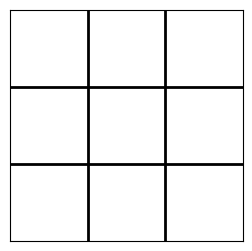

row: 1
col: 2


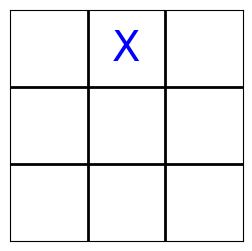

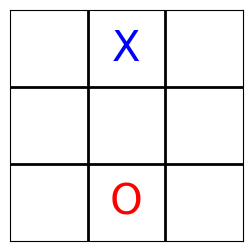

row: 2
col: 1


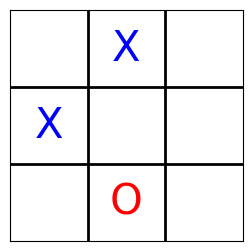

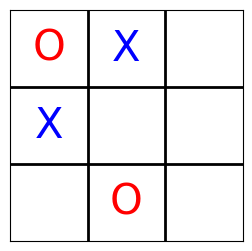

In [ ]:
import copy
import math
import matplotlib.pyplot as plt

X = "X"
O = "O"
EMPTY = None
user = None
ai = None
board = None
ai_turn = False
n = 3

def initial_state():
    """Returns the starting state of the board."""
    return [[EMPTY] * n for _ in range(n)]

def player(board):
    """Returns the player who has the next turn on a board."""
    count = sum(cell is not EMPTY for row in board for cell in row)
    return ai if count % 2 else user

def actions(board):
    """Returns set of all possible actions (i, j) available on the board."""
    return {(i, j) for i in range(n) for j in range(n) if board[i][j] is EMPTY}

def result(board, action):
    """Returns the board that results from making move (i, j) on the board."""
    curr_player = player(board)
    new_board = copy.deepcopy(board)
    new_board[action[0]][action[1]] = curr_player
    return new_board

def winner(board):
    """Returns the winner of the game, if there is one."""
    lines = (
        # Horizontal
        board +
        # Vertical
        list(zip(*board)) +
        # Diagonal
        [[board[i][i] for i in range(n)], [board[i][2 - i] for i in range(n)]]
    )
    for line in lines:
        if line[0] is not EMPTY and all(cell == line[0] for cell in line):
            return line[0]
    return None

def terminal(board):
    """Returns True if game is over, False otherwise."""
    return winner(board) is not None or all(cell is not EMPTY for row in board for cell in row)

def utility(board):
    """Returns 1 if X has won the game, -1 if O has won, 0 otherwise."""
    w = winner(board)
    return 1 if w == X else -1 if w == O else 0

def maxValue(state):
    if terminal(state):
        return utility(state)
    v = -math.inf
    for action in actions(state):
        v = max(v, minValue(result(state, action)))
    return v

def minValue(state):
    if terminal(state):
        return utility(state)
    v = math.inf
    for action in actions(state):
        v = min(v, maxValue(result(state, action)))
    return v

def minimax(board):
    """Returns the optimal action for the current player on the board."""
    current_player = player(board)
    best_value = -math.inf if current_player == X else math.inf
    best_move = None

    for action in actions(board):
        value = minValue(result(board, action)) if current_player == X else maxValue(result(board, action))
        if (current_player == X and value > best_value) or (current_player == O and value < best_value):
            best_value = value
            best_move = action

    return best_move

def draw_board(board):
    """Draws the Tic-Tac-Toe board with grid lines."""
    plt.figure(figsize=(3, 3))  # Smaller figure size
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)
    plt.xticks([])
    plt.yticks([])

    # Draw grid lines
    plt.axhline(y=0.5, color='black', linewidth=2)
    plt.axhline(y=1.5, color='black', linewidth=2)
    plt.axvline(x=0.5, color='black', linewidth=2)
    plt.axvline(x=1.5, color='black', linewidth=2)

    for i in range(3):
        for j in range(3):
            if board[i][j] == X:
                plt.text(j, 2 - i, 'X', fontsize=30, ha='center', va='center', color='blue')
            elif board[i][j] == O:
                plt.text(j, 2 - i, 'O', fontsize=30, ha='center', va='center', color='red')

    plt.grid(False)  # Disable the default grid
    plt.show()

if __name__ == "__main__":
    board = initial_state()
    user = input("Choose a player (X/O): ").strip().upper()
    ai = O if user == X else X

    while True:
        draw_board(board)  # Draw the board here

        if terminal(board):
            game_winner = winner(board)
            if game_winner is None:
                print("Game Over: Tie.")
            else:
                print(f"Game Over: {game_winner} wins.")
            break

        current_player = player(board)

        if current_player == ai:
            move = minimax(board)
            board = result(board, move)
        else:
            try:
                row = int(input("row: ")) - 1
                col = int(input("col: ")) - 1
                if (row, col) in actions(board):
                    board = result(board, (row, col))
                else:
                    print("Invalid move. Try again.")
            except (ValueError, IndexError):
                print("Invalid input. Please enter numbers between 0 and 2.")